In [1]:
# Adapted from https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html
# for kaggle satellite image classification dataset https://www.kaggle.com/mahmoudreda55/satellite-image-classification
# and then basic active learning was applied.

from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from pytorch_finetuning_utils import train_model, train_model_given_numpy_arrays, initialize_model
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
import sys
sys.path.append("..")
from test_framework.model_interface import ModelInterface
from test_framework.tester import Tester
from utils.data_utils import get_kaggle_satellite_image_classification_dataset_as_numpy_arrays
import categorical_query_functions

PyTorch Version:  1.10.0
Torchvision Version:  0.11.1


# parameters

In [2]:
# Top level data directory. Here we assume the format of the directory conforms
#   to the ImageFolder structure
data_dir = "../data/kaggle_satellite_image_classification"

# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet]
model_name = "squeezenet"

# Number of classes in the dataset
num_classes = 4

# Batch size for training (change depending on how much memory you have)
batch_size = 8

# Number of epochs to train for
num_epochs = 3#15

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True

# Use ~1/10 of the dataset
small_dataset = True

# parameters specific to active learning
active_learning_batch_size = 16
initial_train_data_fraction = 0.05
# QUERY_FUNCTION = categorical_query_functions.MIN_MAX
QUERY_FUNCTION = categorical_query_functions.MIN_MARGIN
# QUERY_FUNCTION = categorical_query_functions.MAX_ENTROPY

# Flag for whether to print train loss and accuracy after each epoch.
train_verbose = True

# Load data

In [3]:
x_data,y_data = get_kaggle_satellite_image_classification_dataset_as_numpy_arrays()
order = np.random.permutation(len(x_data))
x_data, y_data = x_data[order], y_data[order]

# Initialize model

In [4]:
# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
print(model_ft.classifier)

Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Conv2d(512, 4, kernel_size=(1, 1), stride=(1, 1))
  (2): ReLU(inplace=True)
  (3): AdaptiveAvgPool2d(output_size=(1, 1))
)


In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
class ActiveLearningModel(ModelInterface):
    def __init__(self,model,name="no name provided",details="no details provided"):
        model.to(device)
        self.model = model
        self._name = name
        self._details = details
        # Gather the parameters to be optimized/updated in this run. If we are
        #  finetuning we will be updating all parameters. However, if we are
        #  doing feature extract method, we will only update the parameters
        #  that we have just initialized, i.e. the parameters with requires_grad
        #  is True.
        params_to_update = model.parameters()
        verbose = False
        if verbose:
            print("Params to learn:")
        if feature_extract:
            params_to_update = []
            for name,param in model.named_parameters():
                if param.requires_grad == True:
                    params_to_update.append(param)
                    if verbose:
                        print("\t",name)
        elif verbose:
            for name,param in model.named_parameters():
                if param.requires_grad == True:
                    print("\t",name)

        # Observe that all parameters are being optimized
        optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)
        self._optimizer = optimizer_ft
        
        # store criterion
        self._criterion = nn.CrossEntropyLoss()

    def name(self) -> str:
        return self._name
    def details(self) -> str:
        return self._details
    def train(self, train_x:np.ndarray, train_y:np.ndarray) -> None:
        self.model = train_model_given_numpy_arrays(self.model, train_x, train_y, self._criterion, self._optimizer, num_epochs, batch_size, verbose=train_verbose)
    def predict(self, test_x:np.ndarray):
        self.model.eval()
        x_tensor = torch.tensor(test_x)
        dataset = TensorDataset(x_tensor)
        dataloader = DataLoader(dataset,batch_size=batch_size,num_workers=0,shuffle=True)
        preds_list = []
        for (inputs,) in dataloader:
            inputs = inputs.to(device)
            preds_list.append(self.model(inputs).cpu().detach().numpy())
        return np.vstack(preds_list)
    def query(self, unlabeled_data:np.ndarray, labeling_batch_size:int) -> np.ndarray:
        softmax = lambda x: np.exp(x)/np.sum(np.exp(x),axis=-1,keepdims=True)
        softmax_outputs = softmax(self.predict(unlabeled_data))
        indices = QUERY_FUNCTION(softmax_outputs,labeling_batch_size)
        return indices

In [7]:
y_data_onehot = np.zeros((y_data.size, y_data.max()+1))
y_data_onehot[np.arange(y_data.size),y_data] = 1

In [8]:
if small_dataset:
    tester = Tester(x_data[:600],y_data_onehot[:600])
else:
    tester = Tester(x_data,y_data_onehot)
tester.TRAINING_EPOCHS = num_epochs
tester.ACTIVE_LEARNING_BATCH_SIZE = active_learning_batch_size
tester.INITIAL_TRAIN_DATA_FRACTION = initial_train_data_fraction

In [9]:
active_learning_model = ActiveLearningModel(model_ft,model_name,str(model_ft.classifier))

In [10]:
tester.test_model(active_learning_model)

Test 0, Training Epoch 0:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0/2
----------


Test 0, Training Epoch 1:   0%|          | 0/10 [00:04<?, ?it/s]

Train Loss: 1.4262 Acc: 0.1111
Epoch 1/2
----------
Train Loss: 1.1763 Acc: 0.3704
Epoch 2/2
----------
Train Loss: 0.9982 Acc: 0.6667

Training complete in 0m 5s
Epoch 0/2
----------
Train Loss: 0.8101 Acc: 0.6296
Epoch 1/2
----------


Test 0, Training Epoch 2:   0%|          | 0/10 [00:04<?, ?it/s]

Train Loss: 0.7606 Acc: 0.6667
Epoch 2/2
----------
Train Loss: 0.7307 Acc: 0.7037

Training complete in 0m 0s
Epoch 0/2
----------
Train Loss: 0.7544 Acc: 0.6296
Epoch 1/2
----------
Train Loss: 0.6271 Acc: 0.8519
Epoch 2/2
----------
Train Loss: 0.6689 Acc: 0.6667

Training complete in 0m 0s


Test 0, Training Epoch 1:  10%|█         | 1/10 [00:05<00:50,  5.57s/it]

Epoch 0/2
----------
Train Loss: 0.7370 Acc: 0.7674
Epoch 1/2
----------
Train Loss: 0.6242 Acc: 0.7907
Epoch 2/2
----------
Train Loss: 0.5731 Acc: 0.7907

Training complete in 0m 0s
Epoch 0/2
----------
Train Loss: 0.5372 Acc: 0.8372
Epoch 1/2
----------
Train Loss: 0.5007 Acc: 0.8140
Epoch 2/2
----------


Test 0, Training Epoch 2:  10%|█         | 1/10 [00:05<00:50,  5.57s/it]

Train Loss: 0.4693 Acc: 0.8372

Training complete in 0m 0s
Epoch 0/2
----------
Train Loss: 0.4100 Acc: 0.8372
Epoch 1/2
----------
Train Loss: 0.3665 Acc: 0.8837
Epoch 2/2
----------
Train Loss: 0.3458 Acc: 0.9302

Training complete in 0m 0s


Test 0, Training Epoch 1:  20%|██        | 2/10 [00:06<00:23,  2.90s/it]

Epoch 0/2
----------
Train Loss: 0.3732 Acc: 0.8644
Epoch 1/2
----------
Train Loss: 0.3231 Acc: 0.8475
Epoch 2/2
----------
Train Loss: 0.2680 Acc: 0.9153

Training complete in 0m 0s
Epoch 0/2
----------


Test 0, Training Epoch 2:  20%|██        | 2/10 [00:06<00:23,  2.90s/it]

Train Loss: 0.2395 Acc: 0.8814
Epoch 1/2
----------
Train Loss: 0.2208 Acc: 0.9322
Epoch 2/2
----------
Train Loss: 0.2257 Acc: 0.9322

Training complete in 0m 0s
Epoch 0/2
----------
Train Loss: 0.2128 Acc: 0.9322
Epoch 1/2
----------
Train Loss: 0.2063 Acc: 0.9492
Epoch 2/2
----------
Train Loss: 0.2045 Acc: 0.9153

Training complete in 0m 0s


Test 0, Training Epoch 0:  30%|███       | 3/10 [00:07<00:14,  2.09s/it]

Epoch 0/2
----------
Train Loss: 0.2635 Acc: 0.8800
Epoch 1/2
----------
Train Loss: 0.2421 Acc: 0.9200
Epoch 2/2
----------


Test 0, Training Epoch 1:  30%|███       | 3/10 [00:07<00:14,  2.09s/it]

Train Loss: 0.2056 Acc: 0.9333

Training complete in 0m 0s
Epoch 0/2
----------
Train Loss: 0.2422 Acc: 0.9200
Epoch 1/2
----------
Train Loss: 0.2291 Acc: 0.9467
Epoch 2/2
----------


Test 0, Training Epoch 2:  30%|███       | 3/10 [00:08<00:14,  2.09s/it]

Train Loss: 0.1792 Acc: 0.9600

Training complete in 0m 0s
Epoch 0/2
----------
Train Loss: 0.2051 Acc: 0.9067
Epoch 1/2
----------
Train Loss: 0.1894 Acc: 0.9333
Epoch 2/2
----------
Train Loss: 0.1753 Acc: 0.9600

Training complete in 0m 0s


Test 0, Training Epoch 0:  40%|████      | 4/10 [00:08<00:10,  1.76s/it]

Epoch 0/2
----------
Train Loss: 0.1615 Acc: 0.9670
Epoch 1/2
----------
Train Loss: 0.2123 Acc: 0.9121
Epoch 2/2
----------


Test 0, Training Epoch 1:  40%|████      | 4/10 [00:09<00:10,  1.76s/it]

Train Loss: 0.1637 Acc: 0.9341

Training complete in 0m 0s
Epoch 0/2
----------
Train Loss: 0.1742 Acc: 0.9670
Epoch 1/2
----------
Train Loss: 0.1562 Acc: 0.9670
Epoch 2/2
----------


Test 0, Training Epoch 2:  40%|████      | 4/10 [00:09<00:10,  1.76s/it]

Train Loss: 0.1681 Acc: 0.9451

Training complete in 0m 0s
Epoch 0/2
----------
Train Loss: 0.1770 Acc: 0.9341
Epoch 1/2
----------
Train Loss: 0.1675 Acc: 0.9341
Epoch 2/2
----------
Train Loss: 0.1670 Acc: 0.9451

Training complete in 0m 0s


Test 0, Training Epoch 0:  50%|█████     | 5/10 [00:10<00:08,  1.63s/it]

Epoch 0/2
----------
Train Loss: 0.1407 Acc: 0.9533
Epoch 1/2
----------
Train Loss: 0.1628 Acc: 0.9626
Epoch 2/2
----------


Test 0, Training Epoch 1:  50%|█████     | 5/10 [00:10<00:08,  1.63s/it]

Train Loss: 0.1670 Acc: 0.9346

Training complete in 0m 0s
Epoch 0/2
----------
Train Loss: 0.1314 Acc: 0.9720
Epoch 1/2
----------


Test 0, Training Epoch 2:  50%|█████     | 5/10 [00:10<00:08,  1.63s/it]

Train Loss: 0.1407 Acc: 0.9720
Epoch 2/2
----------
Train Loss: 0.1654 Acc: 0.9439

Training complete in 0m 0s
Epoch 0/2
----------
Train Loss: 0.1530 Acc: 0.9439
Epoch 1/2
----------
Train Loss: 0.1488 Acc: 0.9439
Epoch 2/2
----------
Train Loss: 0.1251 Acc: 0.9813

Training complete in 0m 0s


Test 0, Training Epoch 0:  60%|██████    | 6/10 [00:11<00:06,  1.60s/it]

Epoch 0/2
----------
Train Loss: 0.1364 Acc: 0.9512
Epoch 1/2
----------


Test 0, Training Epoch 1:  60%|██████    | 6/10 [00:12<00:06,  1.60s/it]

Train Loss: 0.1470 Acc: 0.9512
Epoch 2/2
----------
Train Loss: 0.1311 Acc: 0.9675

Training complete in 0m 0s
Epoch 0/2
----------
Train Loss: 0.1314 Acc: 0.9512
Epoch 1/2
----------
Train Loss: 0.1604 Acc: 0.9431
Epoch 2/2
----------


Test 0, Training Epoch 2:  60%|██████    | 6/10 [00:12<00:06,  1.60s/it]

Train Loss: 0.1300 Acc: 0.9675

Training complete in 0m 0s
Epoch 0/2
----------
Train Loss: 0.1123 Acc: 0.9756
Epoch 1/2
----------
Train Loss: 0.1215 Acc: 0.9593
Epoch 2/2
----------
Train Loss: 0.0864 Acc: 0.9919

Training complete in 0m 0s


Test 0, Training Epoch 0:  70%|███████   | 7/10 [00:13<00:04,  1.61s/it]

Epoch 0/2
----------
Train Loss: 0.1386 Acc: 0.9496
Epoch 1/2
----------


Test 0, Training Epoch 1:  70%|███████   | 7/10 [00:13<00:04,  1.61s/it]

Train Loss: 0.1184 Acc: 0.9712
Epoch 2/2
----------
Train Loss: 0.1365 Acc: 0.9496

Training complete in 0m 0s
Epoch 0/2
----------
Train Loss: 0.1268 Acc: 0.9640
Epoch 1/2
----------
Train Loss: 0.1150 Acc: 0.9712
Epoch 2/2
----------


Test 0, Training Epoch 2:  70%|███████   | 7/10 [00:14<00:04,  1.61s/it]

Train Loss: 0.1186 Acc: 0.9640

Training complete in 0m 0s
Epoch 0/2
----------
Train Loss: 0.1152 Acc: 0.9712
Epoch 1/2
----------
Train Loss: 0.1033 Acc: 0.9784
Epoch 2/2
----------
Train Loss: 0.1240 Acc: 0.9712

Training complete in 0m 0s


Test 0, Training Epoch 0:  80%|████████  | 8/10 [00:15<00:03,  1.67s/it]

Epoch 0/2
----------
Train Loss: 0.1191 Acc: 0.9613
Epoch 1/2
----------


Test 0, Training Epoch 1:  80%|████████  | 8/10 [00:15<00:03,  1.67s/it]

Train Loss: 0.1119 Acc: 0.9677
Epoch 2/2
----------
Train Loss: 0.0956 Acc: 0.9742

Training complete in 0m 0s
Epoch 0/2
----------
Train Loss: 0.1033 Acc: 0.9613
Epoch 1/2
----------
Train Loss: 0.0869 Acc: 0.9806
Epoch 2/2
----------


Test 0, Training Epoch 2:  80%|████████  | 8/10 [00:16<00:03,  1.67s/it]

Train Loss: 0.1027 Acc: 0.9742

Training complete in 0m 0s
Epoch 0/2
----------
Train Loss: 0.0995 Acc: 0.9742
Epoch 1/2
----------
Train Loss: 0.1046 Acc: 0.9742
Epoch 2/2
----------
Train Loss: 0.0790 Acc: 0.9871

Training complete in 0m 0s


Test 0, Training Epoch 0:  90%|█████████ | 9/10 [00:17<00:01,  1.75s/it]

Epoch 0/2
----------
Train Loss: 0.1006 Acc: 0.9766
Epoch 1/2
----------


Test 0, Training Epoch 1:  90%|█████████ | 9/10 [00:17<00:01,  1.75s/it]

Train Loss: 0.1073 Acc: 0.9649
Epoch 2/2
----------
Train Loss: 0.1235 Acc: 0.9532

Training complete in 0m 0s
Epoch 0/2
----------
Train Loss: 0.1027 Acc: 0.9649
Epoch 1/2
----------
Train Loss: 0.0889 Acc: 0.9766
Epoch 2/2
----------


Test 0, Training Epoch 2:  90%|█████████ | 9/10 [00:18<00:01,  1.75s/it]

Train Loss: 0.1013 Acc: 0.9591

Training complete in 0m 0s
Epoch 0/2
----------
Train Loss: 0.0813 Acc: 0.9825
Epoch 1/2
----------
Train Loss: 0.1005 Acc: 0.9708
Epoch 2/2
----------
Train Loss: 0.0944 Acc: 0.9766

Training complete in 0m 0s


Test 0, Training Epoch 2: 100%|██████████| 10/10 [00:19<00:00,  1.93s/it]


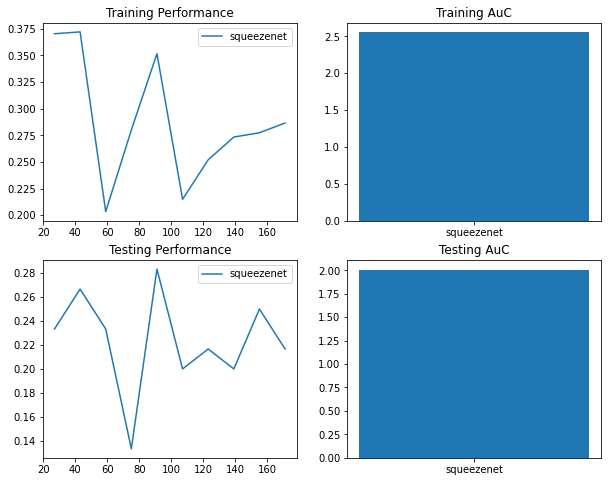

In [11]:
tester.plot_results()